In [1]:
import pickle
import itertools
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy import stats
import os
from config import config_dict
import matplotlib.mlab as mlab

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

pd.options.display.max_columns=100

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/2'):
    os.makedirs('figs/2')

# Load shank dataframe

In [3]:
df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_shanks = df_shanks[df_shanks['burst_type']==0].reset_index()
df_shanks.head()

,index,rat,sess,sh,Fs,elec,burst_type,amp_mean,period_mean,rdsym_mean,ptsym_mean,cycling_frac,N_cycles_all,N_cycles_burst,N_seconds,corr_volt_amp_period_r,corr_volt_amp_period_p,corr_volt_amp_time_rdsym_r,corr_volt_amp_time_rdsym_p,corr_volt_amp_time_ptsym_r,corr_volt_amp_time_ptsym_p,corr_period_time_rdsym_r,corr_period_time_rdsym_p,corr_period_time_ptsym_r,corr_period_time_ptsym_p,corr_time_rdsym_time_ptsym_r,corr_time_rdsym_time_ptsym_p,mv_amp_mean,ms_period_mean
0,0,ec013,ec013.426,4,1250,0,0,2319.532520,161.287866,0.412290,0.414131,0.785563,11644,9362,1537.7272,-0.077456,6.156500e-14,0.040812,7.814688e-05,-0.056677,4.075107e-08,-0.078357,3.143550e-14,0.068883,2.523349e-11,-0.069632,1.533282e-11,2.319533,129.030293
1,4,ec013,ec013.426,5,1250,0,0,2200.710141,161.099577,0.412755,0.419072,0.773503,11619,9229,1537.7200,-0.068670,4.006313e-11,0.062534,1.825662e-09,-0.043223,3.271105e-05,-0.082509,2.039848e-15,0.070847,9.510113e-12,-0.067264,9.909330e-11,2.200710,128.879662
2,8,ec013,ec013.426,6,1250,0,0,1672.178699,161.369480,0.411551,0.448304,0.809731,11680,9646,1537.8640,0.018115,7.523005e-02,0.034804,6.287863e-04,-0.031303,2.106493e-03,-0.010428,3.058098e-01,0.058119,1.115245e-08,-0.090853,3.877569e-19,1.672179,129.095584
3,12,ec013,ec013.426,7,1250,0,0,1693.289664,161.321549,0.415398,0.475218,0.819043,11706,9759,1537.7336,0.010477,3.007297e-01,-0.052982,1.632134e-07,0.057119,1.636914e-08,0.045350,7.401943e-06,0.090220,4.271117e-19,-0.125847,9.571640e-36,1.693290,129.057239
4,16,ec013,ec013.482,4,1250,0,0,1919.829110,166.277068,0.403384,0.438942,0.803501,15953,13069,2163.6064,-0.008160,3.509288e-01,0.024827,4.534006e-03,-0.048778,2.418237e-08,-0.025403,3.680641e-03,0.057749,3.929036e-11,-0.051819,3.078324e-09,1.919829,133.021654


# A-C. Correlations between cycle features, within 1 recording

In [4]:
# Choose a shank
shank_idx = 115 # Arbitrary choice that is representative
rat, sess, sh, Fs = df_shanks.loc[shank_idx, ['rat', 'sess', 'sh', 'Fs']]
file_shapedf = config_dict['mat_path'] + rat + '/' + sess + '/' + str(sh) + '/cycle_by_cycle_shape.csv'
df_shape = pd.read_csv(file_shapedf, index_col=0)
df_shape = df_shape[df_shape['is_burst0']==1].reset_index(drop=True)
df_shape['mv_amp'] = df_shape['volt_amp'] / 1000
df_shape['ms_period'] = df_shape['period'] / Fs * 1000

In [5]:
# Look at correlations between main features
feats = ['mv_amp', 'ms_period', 'time_rdsym', 'time_ptsym']
for feat_pair in itertools.combinations(feats, 2):
    r, p = stats.spearmanr(df_shape[feat_pair[0]], df_shape[feat_pair[1]])
    print('{:s} ~ {:s}, r = {:.2f}, p = {:.0E}'.format(feat_pair[0], feat_pair[1], r, p))

mv_amp ~ ms_period, r = 0.06, p = 1E-05
mv_amp ~ time_rdsym, r = -0.03, p = 9E-03
mv_amp ~ time_ptsym, r = -0.03, p = 3E-02
ms_period ~ time_rdsym, r = 0.06, p = 7E-06
ms_period ~ time_ptsym, r = -0.01, p = 3E-01
time_rdsym ~ time_ptsym, r = -0.21, p = 4E-54


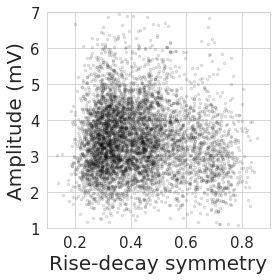

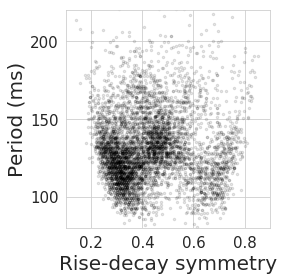

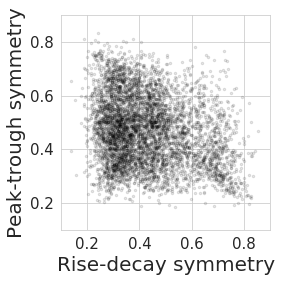

In [6]:
# Plot correlation scatters
pltfmt = {'letter': {'mv_amp': 'A',
                     'ms_period': 'B',
                     'time_ptsym': 'C'},
          'lim': {'mv_amp': (1, 7),
                  'ms_period': (80, 220),
                  'time_ptsym': (.1, .9)},
          'ticks': {'mv_amp': np.linspace(1, 7, 7),
                  'ms_period': np.linspace(50, 250, 5),
                  'time_ptsym': np.linspace(0, 1, 6)},
          'label': {'mv_amp': 'Amplitude (mV)',
                  'ms_period': 'Period (ms)',
                  'time_ptsym': 'Peak-trough symmetry'}
         }
other_feats = ['mv_amp', 'ms_period', 'time_ptsym']
for feat in pltfmt['lim'].keys():
    plt.figure(figsize=(4, 4))
    plt.plot(df_shape['time_rdsym'], df_shape[feat], 'k.', ms=5, alpha=.1)
    plt.xticks(np.linspace(0, 1, 6))
    plt.yticks(pltfmt['ticks'][feat])
    plt.xlim((.1, .9))
    plt.ylim(pltfmt['lim'][feat])
    plt.xlabel('Rise-decay symmetry')
    plt.ylabel(pltfmt['label'][feat])
    plt.tight_layout()
    plt.savefig('figs/2/{:s}.png'.format(pltfmt['letter'][feat]))

# D-F. Cycle feature correlation coefs across recordings

In [7]:
# Look at consistency in correlations between main features
feats = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
print('N =', len(df_shanks))
for feat_pair in itertools.combinations(feats, 2):
    x = df_shanks['corr_{:s}_{:s}_r'.format(feat_pair[0], feat_pair[1])]
    r, p = stats.wilcoxon(x)
    print('{:10s} ~ {:10s}, W = {:4.0f}, p = {:.0E}, avg rho = {:.3f}'.format(feat_pair[0], feat_pair[1], r, p, np.mean(x)))

N = 152
volt_amp   ~ period    , W = 5098, p = 2E-01, avg rho = 0.009
volt_amp   ~ time_rdsym, W = 2740, p = 2E-08, avg rho = -0.025
volt_amp   ~ time_ptsym, W = 2368, p = 2E-10, avg rho = -0.036
period     ~ time_rdsym, W = 2835, p = 4E-08, avg rho = 0.038
period     ~ time_ptsym, W = 3781, p = 2E-04, avg rho = -0.018
time_rdsym ~ time_ptsym, W =   28, p = 2E-26, avg rho = -0.114


/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


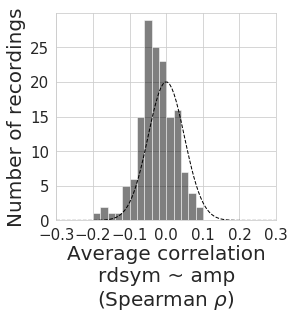

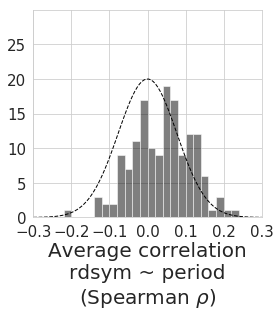

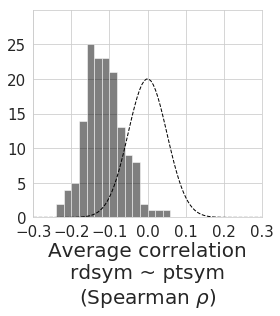

In [8]:
# Plot correlation scatters
pltfmt = {'letter': {'mv_amp': 'D',
                     'ms_period': 'E',
                     'time_ptsym': 'F'},
          'corrstr': {'mv_amp': 'volt_amp_time_rdsym',
                     'ms_period': 'period_time_rdsym',
                     'time_ptsym': 'time_rdsym_time_ptsym'},
          'short': {'mv_amp': 'amp',
                     'ms_period': 'period',
                     'time_ptsym': 'ptsym'},
          'lim': {'mv_amp': (1, 4),
                  'ms_period': (80, 180),
                  'time_ptsym': (.2, .8)},
          'ticks': {'mv_amp': np.linspace(1, 4, 4),
                  'ms_period': np.linspace(80, 180, 6),
                  'time_ptsym': np.linspace(.2, .8, 4)},
          'figsize': {'mv_amp': (4.2,4.5),
                  'ms_period': (4,4.5),
                  'time_ptsym': (4,4.5)}
         }
other_feats = ['mv_amp', 'ms_period', 'time_ptsym']
for feat in pltfmt['lim'].keys():
    plt.figure(figsize=pltfmt['figsize'][feat])
    histplt = df_shanks['corr_{:s}_r'.format(pltfmt['corrstr'][feat])]
    plt.hist(histplt, bins=np.arange(-.3,.31, .02), color='k', alpha=.5)
    
    # Plot null Gaussian
    x_gauss = np.linspace(-.3,.3, 100)
    y_gauss = mlab.normpdf(x_gauss, 0, np.std(histplt))
    y_gauss = y_gauss * 20 / np.max(y_gauss)
    plt.plot(x_gauss, y_gauss, 'k--')
    
    plt.xticks(np.arange(-.3,.32,.1))
    plt.xlim((-.3, .3))
    plt.yticks(np.arange(0, 30, 5))
    plt.ylim((0, 30))
    
    if feat == 'mv_amp':
        plt.ylabel('Number of recordings')
    plt.xlabel('Average correlation\nrdsym ~ '+pltfmt['short'][feat]+'\n(Spearman $\\rho$)')
    plt.tight_layout()
    plt.savefig('figs/2/{:s}.png'.format(pltfmt['letter'][feat]))

# G. Autocorrelations of cycle features

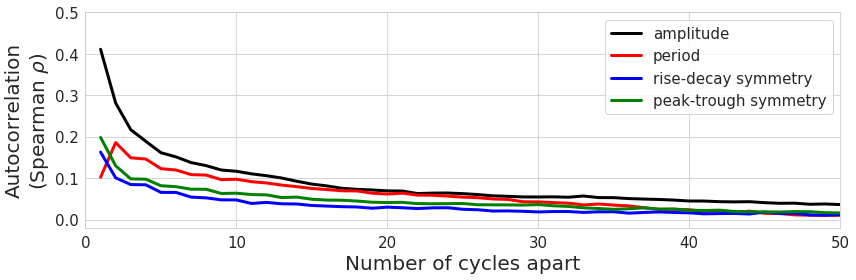

In [9]:
# Load autocorrelation values
autocorr_rs_by_shank = pickle.load(open(config_dict['processed_path']+'cycle_autocorrelations.pkl', 'rb'))
autocorr_feats = autocorr_rs_by_shank.keys()

# Compute average autocorrelation for each feature
autocorr_avg = {}
for feat in autocorr_feats:
    autocorr_avg[feat] = np.nanmean(autocorr_rs_by_shank[feat], axis=0)

# Figure formatting
feats = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
short_feat = {'volt_amp': 'amplitude', 'period': 'period',
              'time_rdsym': 'rise-decay symmetry',
              'time_ptsym': 'peak-trough symmetry'}
colors = {'volt_amp': 'k', 'period': 'r', 'time_rdsym': 'b', 'time_ptsym': 'g'}

# Plot autocorrelation for each feature
plt.figure(figsize=(12,4))
for feat in feats:
    plt.plot(config_dict['autocorr_delays'], autocorr_avg[feat],
             label=short_feat[feat], linewidth=3, color=colors[feat])
plt.legend(fontsize=15)
plt.xlabel('Number of cycles apart')
plt.ylabel('Autocorrelation\n(Spearman $\\rho$)')
plt.xlim((0,50))
plt.ylim((-.02, .5))
plt.tight_layout()
plt.savefig('figs/2/G.png')